<big>**TODO**: should be updated based on ver4_machine_learning_flight_classification_tsne_cfg3_20190628_2_gtu_40_overlap_cls20190728.ipynb</big>

# Flight data classification using convnet szakacs triple_net

- Using the most recent version of the manualy classified events - events classified until **2019/07/28**
- Classified using model 20190628_2
- Compared to the events classified until approximatelly 2019/07/01 (20190628_2) 
- Considered events in GTU range **ending after GTU 40 and starting not later then GTU 45**

In [45]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools
import time

# import sklearn.preprocessing
# import sklearn.feature_selection
# import sklearn.ensemble 
# import sklearn.neural_network
# import sklearn.model_selection
# import sklearn.metrics
# import sklearn.pipeline
# from sklearn.externals import joblib

# mpl.use('Agg')
mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as sm_stats_proportion

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [38]:
classification_id = '20190628_2'
model_data_snippets_dir = 'ver4_machine_learning_convnet_szakcs_w_labeled_flight_{}__v2'.format(classification_id)

data_snippets_dir = \
    'ver4_machine_learning_flight_classification_' + classification_id + '_gtu_40_overlap_cls20190728' + \
    '__convnet_szakacs_triple_net'

subset_classification_slug = \
    'ver4_ml_' + classification_id + '_gtu_40_overlap_cls20190728' + \
    '__cnn_sz_triple_net'

os.makedirs(data_snippets_dir, exist_ok=True)

In [43]:
covnet_euso_base_dir = '/mnt/data_wdblue3d1/spbproc/convnet_euso'
covnet_euso_docker_dir = covnet_euso_base_dir
covnet_euso_dockerfile = os.path.join(covnet_euso_docker_dir, 'Dockerfile-gpu')
covnet_euso_src_dir = os.path.join(covnet_euso_base_dir, 'src')

# Selecting the flight data

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight, config_w_flatmap_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False,
    return_global_config=True
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [5]:
def load_inverse_means_frame_arr(config, calibration_map_path=None, ret_calibration_map_path=False, ret_arr=True):
    import process_acquisition_file
    
    if not calibration_map_path:
        if 'ProcessAcquisitionsParams' in config and 'calibration_map_path' in config['ProcessAcquisitionsParams']:
            calibration_map_path = config['ProcessAcquisitionsParams']['calibration_map_path']
        if 'FeatureExtractionParams' in config and 'calibration_map_path' in config['FeatureExtractionParams']:
            calibration_map_path = config['FeatureExtractionParams']['calibration_map_path']

    if calibration_map_path:
        inverse_means_frame_pathname, inverse_means_frame_arr = \
            process_acquisition_file.prepare_inverse_means_file(
                calibration_map_path, os.path.dirname(calibration_map_path),
                exist_ok=True, load_if_exists=True)
        if ret_calibration_map_path:
            if ret_arr:
                return calibration_map_path, inverse_means_frame_arr
            return calibration_map_path
        elif ret_arr:
            return inverse_means_frame_arr
    if ret_calibration_map_path and ret_arr:
        return None, None
    elif ret_calibration_map_path or ret_arr:
        return None

In [6]:
inverse_means_frame_arr = load_inverse_means_frame_arr(config_w_flatmap_flight)

## Columns

In [7]:
common_included_columns_re_list = [
    ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
    'trg_((gtu|x)_[yx])_hough_peak_thr1_major_line_phi', 
    ('orig_x_y','count_nonzero')
]

In [8]:
trg_phi_col = 'trg_x_y_hough_peak_thr2_max_peak_clu_major_line_phi'

additional_column_names = [
    trg_phi_col,
    'proc2_x_y_hough_peak_thr2_max_peak_clu_major_line_phi',
    'proc2_x_y_hough_peak_thr2_max_peak_clu_major_line_rho',
    'proc2_gtu_x_hough_peak_thr2_major_line_phi',
    'proc2_gtu_x_hough_peak_thr2_major_line_rho',
    'proc2_gtu_y_hough_peak_thr2_major_line_phi',
    'proc2_gtu_y_hough_peak_thr2_major_line_rho',
]

dataset_compatibility_column_names = list(set([
#  'trg_x_y_clusters_max_peak_clu_width',
#  'trg_gtu_x_clusters_max_peak_clu_width',
#  'trg_gtu_y_clusters_max_size_clu_width',
 'proc2_x_y_clusters_max_peak_clu_width',
#  'proc3_x_y_clusters_max_peak_clu_width',
#  'proc2_gtu_x_clusters_max_peak_clu_width',
#  'proc3_gtu_y_clusters_max_peak_clu_width',
#  'alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width',
    
 'proc1_gtu_x_hough_peak_thr3_major_line_rho',

]))

In [9]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list= \
        common_included_columns_re_list + \
        ['gps_datetime_min', ('^$', 'timestamp') ] + \
        additional_column_names + dataset_compatibility_column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=dataset_compatibility_column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- timestamp
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_orig_x_y
	- count_nonzero

spb_processing_v4_flatmap.event_proc2_x_y_clusters
	- max_peak_clu_width

spb_processing_v4_flatmap.event_trg_x_y_hough_peak_thr1
	- major_line_phi

spb_processing_v4_flatmap.event_trg_x_y_hough_peak_thr2
	- max_peak_clu_major_line_phi

spb_processing_v4_flatmap.event_trg_gtu_x_hough_peak_thr1
	- major_line_phi

spb_processing_v4_flatmap.event_trg_gtu_y_hough_peak_thr1
	- major_line_phi

spb_processing_v4_flatmap.event_proc2_x_y_hough_peak_thr2
	- max_peak_clu_major_line_phi
	- max_peak_clu_major_line_rho

spb_processing_v4_flatmap.event_proc1_gtu_x_hough_peak_thr3
	- major_line_rho

spb_processing_v4_flatmap.event_proc2_gtu_x_hough_peak_thr2
	- major_line_

## Event classes

In [10]:
EVENT_CLASSES = {
    'pixel': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_pixels': 6,
    'bg_increased_suddenly': 10,
    'persistent_pixel': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_pixels': 17,
    'pixel_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_weak_pixel': 21,
    #
    'unclassified': -1
}

In [11]:
EVENT_CLASSES_LABELS = {
    'Pixel': 2,
    'Top-left EC': 5,
    'Blob': 12,
    'Large blob': 11,
    'Short single GTU track': 7,
    'Single GTU track': 3,
    'Noise': 1,
    'Cartesian line': 4,
    'Strong MA-PMT edge': 9,
    'Few pixels': 6,
    'Sudden bg. increased': 10,
    'Persistent pixel': 14,
    'Unspecified noise': 0,
    'Unspecified': 8,
    'Air shower': 13,
    '2 pix line': 15,
    'Bright blob': 16,
    'Blob and pixels': 17,
    'Pixel with a blob behind': 18,
    'Storng light': 19,
    'Sparse blobs': 20,
    'Noise with a weak pixel': 21,
    #
    'Unclassified': -1
}

In [12]:
len(EVENT_CLASSES)

23

In [13]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

In [14]:
INVERSE_EVENT_CLASSES_LABELS = {v: k for k, v in EVENT_CLASSES_LABELS.items()}

## Constructing the query

In [15]:
manual_classification_table_name_w_schema = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
manual_classification_attr_prefix = event_v3_storage_provider_flight.get_group_from_table_name(manual_classification_table_name_w_schema)

manual_classification_class_number_column_base = 'class_number'
manual_classification_last_mod_column_base = 'last_modification'

manual_classification_class_number_column = manual_classification_attr_prefix + '_' + manual_classification_class_number_column_base
manual_classification_last_mod_column = manual_classification_attr_prefix + '_' + manual_classification_last_mod_column_base

In [16]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

# AND abs(gtu_in_packet-42) < 20
flight_where_clauses_str = ''' 
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [17]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.timestamp, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_gps_datetime.min AS gps_datetime_min, spb_processing_v4_flatmap.event_orig_x_y.count_nonzero AS orig_x_y_count_nonzero, spb_processing_v4_flatmap.event_proc2_x_y_clusters.max_peak_clu_width AS proc2_x_y_clusters_max_peak_clu_width, spb_processing_v4_flatmap.event_trg_x_y_hough_peak_thr1.major_line_phi AS trg_x_y_hough_peak_thr1_major_line_phi, spb_processing_v4_flatmap.event_trg_x_y_hough_peak_thr2.max_peak_clu_major_line_phi AS trg_x_y_hough_p

## Data selection

In [18]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [19]:
len(flight_df)

206428

### Distance from GTU 40

In [20]:
flight_df['dist_gtu_40'] = np.abs(flight_df['gtu_in_packet'] - 40)

### Event manual classification

In [21]:
np.count_nonzero(~flight_df[manual_classification_class_number_column].isnull())

4833

In [22]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = EVENT_CLASSES['unclassified']

In [23]:
manual_classification_class_name_column = 'manual_classification_class_name'
manual_classification_class_label_column = 'manual_classification_class_label'

In [24]:
flight_df[manual_classification_class_name_column] = INVERSE_EVENT_CLASSES[-1]
flight_df[manual_classification_class_label_column] = INVERSE_EVENT_CLASSES_LABELS[-1]
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name
for class_label, class_number in EVENT_CLASSES_LABELS.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_label_column] = class_label

In [28]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [29]:
# making presumption jut to be consistent with http://localhost:8888/notebooks/ver4_machine_learning_flight_classification_tsne_cfg3_20190628_2_gtu_40_overlap_cls20190728.ipynb
flight_df['had_nan_fields'] = False

In [30]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [31]:
len(flight_df_nonan)

206428

## Additional counts for comparson

In [32]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [33]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 45
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event
        JOIN spb_processing_v4_flatmap.event_orig_x_y USING (event_id) 
        WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 45
        AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_cnz6ec_packets = cur.fetchone()[0]


cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 45
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_events = cur.fetchone()[0]


cur.execute('''
    SELECT COUNT(event_id) 
    FROM spb_processing_v4_flatmap.event 
    JOIN spb_processing_v4_flatmap.event_orig_x_y USING (event_id)
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 45
    AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_cnz6ec_events = cur.fetchone()[0]

In [34]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('number of gtu [36,45] packets', num_gtu_36_45_packets)
print('number of gtu [36,45] packets (6EC+)', num_gtu_36_45_cnz6ec_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('number of gtu [36,45] events ', num_gtu_36_45_events)
print('number of gtu [36,45] events (6EC6)', num_gtu_36_45_cnz6ec_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))
print('sel. fraction of gtu [36,45] events {:.3f}, inv: {:.3f} (not exact)'.format(len(flight_df_nonan) / num_gtu_36_45_events, num_gtu_36_45_events / len(flight_df_nonan))) 
print('sel. fraction of gtu [36,45] events {:.3f}, inv: {:.3f} (6EC+)'.format(len(flight_df_nonan) / num_gtu_36_45_cnz6ec_events, num_gtu_36_45_cnz6ec_events / len(flight_df_nonan))) 

number of all         packets 148327
number of gtu [36,60] packets 139865
number of gtu [31,67] packets 142478
number of gtu [36,45] packets 135021
number of gtu [36,45] packets (6EC+) 118141
--------------------------------------------------
number of all         events  247316
number of gtu [36,60] events  159080
number of gtu [31,67] events  170427
number of gtu [36,45] events  135799
number of gtu [36,45] events (6EC6) 118820
--------------------------------------------------
sel. fraction of all         events 0.835
sel. fraction of gtu [36,60] events 1.298
sel. fraction of gtu [31,67] events 1.211
sel. fraction of gtu [36,45] events 1.520, inv: 0.658 (not exact)
sel. fraction of gtu [36,45] events 1.737, inv: 0.576 (6EC+)


Note: Fractions should be recalculated after refining the selection of events

In [35]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT(*) FROM (SELECT DISTINCT source_file_acquisition, packet_id  FROM spb_processing_v4_flatmap.event WHERE source_data_type_num=1) AS s;

## Preparation of datasets for convnet - szakacs

In [ ]:
# def get_inverse_means_arr(r, inverse_means_frame_arr=inverse_means_frame_arr):
#     if r['source_class'] in ((EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_LABLELED_NOISE_FLIGHT, EVENT_CLASS_NUMBER_UNLABELED_NOISE)):
#         return inverse_means_frame_arr
#     return None

In [72]:
gtu_proj_num_frames = 30
data_export_dir = os.path.join(data_snippets_dir, 'data')  # TODO gtu_proj_num_frames should be incorporated into the file name
data_export_for_trainer_dir = os.path.join(data_snippets_dir, 'data_for_trainer')  # TODO gtu_proj_num_frames should be incorporated into the file name

os.makedirs(data_export_dir, exist_ok=True)
os.makedirs(data_export_for_trainer_dir, exist_ok=True)

subset_name = 'flight'

# -----------------------------------

tsv_file_pathname = os.path.join(data_export_dir, '{}_meta.tsv.gz'.format(subset_name))
tsv_file_for_trainer_pathname = os.path.join(data_export_for_trainer_dir, '{}_meta.tsv'.format(subset_name))

if not os.path.exists(tsv_file_pathname):
    print('Saving:', tsv_file_pathname)
    flight_df.to_csv(tsv_file_pathname, sep='\t', compression='gzip',
                                           index=True, index_label='index')

else:
    print('Already exists:', tsv_file_pathname)

if not os.path.exists(tsv_file_for_trainer_pathname):
    print('Saving:', tsv_file_for_trainer_pathname)
    flight_df.to_csv(tsv_file_for_trainer_pathname, sep='\t',
                                           index=True, index_label='index')

else:
    print('Already exists:', tsv_file_for_trainer_pathname)

# ----------------------------------

output_npz_pathname = os.path.join(data_export_dir, '{}.npz'.format(subset_name))
untranasposed_output_npz_pathname = os.path.join(data_export_for_trainer_dir, '{}.npz'.format(subset_name))

_frames = None

if not os.path.exists(output_npz_pathname):
    print('Saving:', output_npz_pathname)

    x_y_list, gtu_y_list, gtu_x_list = \
        get_frame_array(
            flight_df, inverse_means_arr=inverse_means_frame_arr,
            x_y_num_gtu_overwrite=None, gtu_x_num_gtu_overwrite=gtu_proj_num_frames, gtu_y_num_gtu_overwrite=gtu_proj_num_frames,
            return_x_y=True, return_gtu_x=True, return_gtu_y=True)

    _frames = {
        'x_y': np.array(x_y_list), 'gtu_y': np.array(gtu_y_list), 'gtu_x': np.array(gtu_x_list)
    }

    np.savez_compressed(output_npz_pathname, **_frames)

    _frames = {
        'x_y': _frames['x_y'], 
        'gtu_y': np.transpose(_frames['gtu_y'], (0, 2, 1)), 
        'gtu_x': np.transpose(_frames['gtu_x'], (0, 2, 1))
    }

    np.savez_compressed(untranasposed_output_npz_pathname, **_frames)

else:
    print('Already exists:', output_npz_pathname)

if not os.path.exists(untranasposed_output_npz_pathname):
    print('Saving:', untranasposed_output_npz_pathname)
    _frames = np.load(output_npz_pathname)
    _frames = {
        'x_y': _frames['x_y'], 
        'gtu_y': np.transpose(_frames['gtu_y'], (0, 2, 1)), 
        'gtu_x': np.transpose(_frames['gtu_x'], (0, 2, 1))
    }

    np.savez_compressed(untranasposed_output_npz_pathname, **_frames)

else:
    print('Already exists:', untranasposed_output_npz_pathname)

del _frames

# ----------------------------------
# pointless, just to satisfy model_checker.py

        
output_npy_pathname = os.path.join(data_export_for_trainer_dir, '{}_class_targets.npy'.format(subset_name))

if not os.path.exists(output_npy_pathname):
    print('Saving:',output_npy_pathname)

    _targets_col_uint8 = np.zeros(len(flight_df)).reshape(-1,1)

    np.save(output_npy_pathname, np.hstack((_targets_col_uint8, 1 - _targets_col_uint8)))

    del _targets_col_uint8

else:
    print('Already exists:',output_npy_pathname)



# ----------------------------------

config_ini_file = os.path.join(data_export_for_trainer_dir, '{}_config.ini'.format(subset_name))

if not os.path.exists(config_ini_file):
    print('Saving', config_ini_file)
    config_file_content = \
'''[general]
num_data = {list_len}
metafields = {{}}
dtype = float32

[packet_shape]
num_frames = {num_frames}
frame_height = 48
frame_width = 48

[item_types]
raw = False
yx = True
gtux = True
gtuy = True
'''.format(
        list_len=len(flight_df),
        num_frames=gtu_proj_num_frames
    )
    with open(config_ini_file, 'w+') as f:
        f.write(config_file_content)

else:
    print('Already exists', config_ini_file)


Already exists: ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data/flight_meta.tsv.gz
Already exists: ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data_for_trainer/flight_meta.tsv
Already exists: ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data/flight.npz
Already exists: ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data_for_trainer/flight.npz
Saving: ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data_for_trainer/flight_class_targets.npy
Already exists ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data_for_trainer/flight_config.ini


# Applying models

## Convnet - triple_net

### Docker container run related functions

In [52]:
def get_docker_volume_paths(data_export_dir, model_trainer_output_dir):
    volume_dirs = {'export_dir': data_export_dir, 'trainer_dir': model_trainer_output_dir}
    in_container_dirs = {}
    volumes_set = set()
    common_path = os.path.commonpath(volume_dirs.values())
    if common_path:
        common_path_realpath = os.path.realpath(common_path)
        common_path_basename = os.path.basename(common_path)
    for k, d in volume_dirs.items():
        if common_path and d.startswith(common_path):
            volumes_set.add('{}:/{}'.format(common_path_realpath, common_path_basename))
            in_container_dirs[k] = '/' + os.path.join(common_path_basename, d[len(common_path)+1:])
        else:
            volumes_set.add('{}:/{}'.format(os.path.realpath(d), d))
            in_container_dirs[k] = '/' + d
    
    return volumes_set, in_container_dirs

In [40]:
def _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, stdout_file_reader=None, stderr_file_reader=None):

        proc = subprocess.Popen(cmd, shell=True, stdout=stdout_file_writer, stderr=stderr_file_writer)

        if stdout_file_reader is not None or stderr_file_reader is not None:
            
            while proc.poll() is None:
                if stdout_file_reader is not None:
                    sys.stdout.write(stdout_file_reader.read())
                if stderr_file_reader is not None:
                    sys.stderr.write(stderr_file_reader.read())
                time.sleep(1)

            if stdout_file_reader is not None:
                sys.stdout.write(stdout_file_reader.read())
            if stderr_file_reader is not None:
                sys.stderr.write(stderr_file_reader.read())
        
        else:
            proc.wait()
        
        return proc

def run_subprocess_w_output(cmd, output_pathname_prefix, writer_buffer=0, reader_buffer=0, use_reader=False):

    stdout_file_pathname = output_pathname_prefix + '_stdout.txt'
    stderr_file_pathname = output_pathname_prefix + '_stderr.txt'
    
    if use_reader:
        with \
                open(stdout_file_pathname, 'wb', writer_buffer) as stdout_file_writer, \
                open(stdout_file_pathname, 'rb', reader_buffer) as stdout_file_reader, \
                open(stderr_file_pathname, 'wb', writer_buffer) as stderr_file_writer, \
                open(stderr_file_pathname, 'rb', reader_buffer) as stderr_file_reader:
            proc = _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, stdout_file_reader, stderr_file_reader)
    
    else:
        with \
                open(stdout_file_pathname, 'wb', writer_buffer) as stdout_file_writer, \
                open(stderr_file_pathname, 'wb', writer_buffer) as stderr_file_writer:
            proc = _run_subprocess_w_output(cmd, stdout_file_writer, stderr_file_writer, None, None)
    
    return proc

### Prediction by convnet_euso

In [145]:
net_model='triple_net'
model_trainer_output_dir = os.path.join(data_snippets_dir, 'model_trainer', net_model)
os.makedirs(model_trainer_output_dir, exist_ok=True)
volumes_set, in_container_dirs = \
    get_docker_volume_paths(data_export_for_trainer_dir, model_trainer_output_dir)

In [146]:
evaluated_set_name = 'flight'
predictions_tsv_name = evaluated_set_name + '_predictions.tsv'
classifier_results_tsv_pathname = os.path.join(model_trainer_output_dir, predictions_tsv_name)

rerun = False

model_checker_run_cmd_str = (
    'docker run --rm --gpus all {volumes} -v {src}:/src -w /src convnet_euso:0.35 python3 -u model_checker.py ' 
    '--name {evaluated_set_name} --srcdir {export_dir} --tb_dir {trainer_dir} '
    '--load_yx --load_gtux --load_gtuy -n {net_model} -m {model_file} {outfile}' 
).format(
    volumes=' '.join('-v '+v for v in volumes_set),
    src=covnet_euso_src_dir,
    evaluated_set_name=evaluated_set_name,
    net_model=net_model,
    export_dir=in_container_dirs['export_dir'],
    trainer_dir=in_container_dirs['trainer_dir'],
    model_file=os.path.join(in_container_dirs['trainer_dir'], 'net.triple_net.tflearn'),
    outfile=os.path.join(in_container_dirs['trainer_dir'], predictions_tsv_name)
)

print('-'*100)
print(model_checker_run_cmd_str)
print('-'*100)

if not os.path.exists(classifier_results_tsv_pathname) or rerun:
    run_subprocess_w_output(
        model_checker_run_cmd_str, 
        os.path.join(model_trainer_output_dir, 'model_checker_on_' + evaluated_set_name), 
        use_reader=True
    )

----------------------------------------------------------------------------------------------------
docker run --rm --gpus all -v /mnt/data_900p/EUSO-Balloon/vrabel/notebooks/ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net:/ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net -v /mnt/data_wdblue3d1/spbproc/convnet_euso/src:/src -w /src convnet_euso:0.35 python3 -u model_checker.py --name flight --srcdir /ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/data_for_trainer --tb_dir /ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/model_trainer/triple_net --load_yx --load_gtux --load_gtuy -n triple_net -m /ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/model_trainer/triple_net/net.triple_ne

In [74]:
classifier_results_tsv_pathname

'ver4_machine_learning_convnet_szakcs_w_labeled_flight_20190628_2__v2/model_trainer/triple_net/flight_predictions.tsv'

In [75]:
model_checker_predictions_on_flight_df = pd.read_csv(
    classifier_results_tsv_pathname, sep='\t'
)

In [76]:
cls_column_base = 'convnet_euso_triple_net'
cls_column = cls_column_base
cls_proba_column = cls_column_base + '_proba'

# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )

flight_df[cls_proba_column] = model_checker_predictions_on_flight_df['shower_prob'].values
flight_df[cls_column] = np.round(flight_df[cls_proba_column])

# Refining the selection

In [77]:
flight_df_pack = flight_df \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')

## Same as 20190628_2_gtu_40

In [78]:
len(flight_df[(flight_df['gtu_in_packet'] - 42).abs() < 20])

148972

## GTU range overlapping GTU 40-45

In [79]:
flight_df_gtu_overlap = flight_df[
    ((flight_df.gtu_in_packet -4 + flight_df.num_gtu) > 40)  & 
    (flight_df['gtu_in_packet'] <= 45) 
 ]

### Only single packet

In [80]:
flight_df_gtu_overlap_pack = flight_df_gtu_overlap \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')

In [81]:
len(flight_df_gtu_overlap_pack)

119551

In [82]:
flight_df_gtu_overlap_pack.sort_values('gtu_in_packet') \
[['event_id', 'source_file_acquisition', 'packet_id', 'gtu_in_packet', 'dist_gtu_40', manual_classification_class_name_column]]

,event_id,source_file_acquisition,packet_id,gtu_in_packet,dist_gtu_40,manual_classification_class_name
index,,,,,,
144182,162458,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1255,1,39,unclassified
39332,47167,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,265,1,39,unclassified
38717,46457,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,242,1,39,unclassified
36882,44324,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,182,1,39,unclassified
818,1273,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,59,1,39,unclassified
144811,163141,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1336,1,39,unclassified
721,1122,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,47,1,39,unclassified
677,1062,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,43,1,39,unclassified
144587,162900,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1308,1,39,unclassified


### Experiment-wise common dataset
(trigger related features are avialable)

In [83]:
flight_df_gtu_overlap_pack_common = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack[trg_phi_col].isnull()]

In [84]:
len(flight_df_gtu_overlap_pack_common)

110234

In [85]:
# does not make much sense
len(flight_df_gtu_overlap_pack_common) / num_gtu_36_45_cnz6ec_packets

0.9330714993101463

## GTU range [36, 45]

In [86]:
flight_df_gtu_36_45 = flight_df[(flight_df['gtu_in_packet'] >= 36) & (flight_df['gtu_in_packet'] <= 45)]

In [87]:
len(flight_df_gtu_36_45)

118820

In [88]:
len(flight_df_gtu_36_45) / num_gtu_36_45_cnz6ec_events

1.0

### Only single packet

In [89]:
flight_df_gtu_36_45_pack = flight_df_gtu_36_45 \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')
flight_df_gtu_36_45_pack_nonan = flight_df_gtu_36_45.dropna()

In [90]:
len(flight_df_gtu_36_45_pack)

118141

In [91]:
len(flight_df_gtu_36_45_pack) / num_gtu_36_45_cnz6ec_packets

1.0

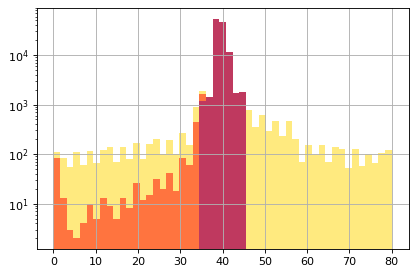

In [92]:
flight_df_pack.gtu_in_packet.hist(bins=51, alpha=.5, color='gold', range=(0,80))
flight_df_gtu_36_45_pack.gtu_in_packet.hist(bins=51, alpha=.5, color='blue', range=(0,80))
flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=51, alpha=.5, color='red', range=(0,80))
plt.gca().set_yscale('log')
plt.show()

### Updating `flight_df_nonan` with classification predictions
(not in the report)

In [93]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]
flight_df_gtu_overlap_pack_nonan = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack['had_nan_fields']]
flight_df_gtu_overlap_pack_common_nonan = flight_df_gtu_overlap_pack_common[~flight_df_gtu_overlap_pack_common['had_nan_fields']]

### Statistics of selected events

#### Number of events classified "air shower"

In [94]:
np.count_nonzero(flight_df_nonan[cls_column])

7997

In [95]:
np.count_nonzero(flight_df_gtu_36_45[cls_column])

6720

In [96]:
np.count_nonzero(flight_df_gtu_overlap[cls_column])

6927

In [97]:
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column])

6912

In [98]:
np.count_nonzero(flight_df_gtu_overlap_pack_common_nonan[cls_column])

6776

### Events classified "air shower" - fraction of classified events

In [99]:
np.count_nonzero(flight_df_nonan[cls_column])/len(flight_df_nonan)

0.03873989962601972

In [100]:
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column]) / num_gtu_36_45_cnz6ec_packets

0.058506361043160295

In [101]:
np.count_nonzero(flight_df_gtu_overlap_pack_common_nonan[cls_column]) / num_gtu_36_45_cnz6ec_packets

0.05735519421707959

#### Events classified "air shower" - describe

In [102]:
flight_df_nonan[[cls_column, cls_proba_column]].describe()

,convnet_euso_triple_net,convnet_euso_triple_net_proba
count,206428.000000,206428.000000
mean,0.038740,0.045439
std,0.192975,0.170610
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000800
max,1.000000,1.000000


In [103]:
flight_df_gtu_overlap_pack_nonan[[cls_column, cls_proba_column]].describe()

,convnet_euso_triple_net,convnet_euso_triple_net_proba
count,119551.000000,119551.000000
mean,0.057816,0.062899
std,0.233397,0.206158
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [104]:
flight_df_gtu_overlap_pack_common_nonan[[cls_column, cls_proba_column]].describe()

,convnet_euso_triple_net,convnet_euso_triple_net_proba
count,110234.000000,110234.000000
mean,0.061469,0.066807
std,0.240190,0.212130
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


#### Events classified "air shower" - number of events by probability

##### flight_df_nonan

In [105]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df[cls_proba_column] > proba)))

p > 0.50: 7997
p > 0.60: 7065
p > 0.70: 6165
p > 0.80: 5157
p > 0.90: 3803


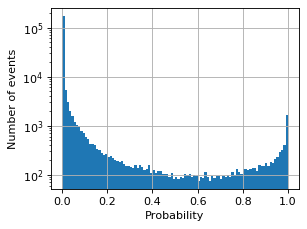

In [106]:
fig, ax = plt.subplots(figsize=(4,3))
flight_df_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, cls_proba_column +'_distribution_horizontal.svg'))
plt.show()

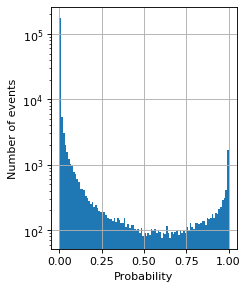

In [107]:
fig, ax = plt.subplots(figsize=(3,4))
flight_df_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, cls_proba_column +'_distribution_vertical.svg'))
plt.show()

##### flight_df_gtu_36_45_pack_nonan

In [108]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df_gtu_36_45_pack_nonan[cls_proba_column] > proba)))

p > 0.50: 6149
p > 0.60: 5505
p > 0.70: 4837
p > 0.80: 4081
p > 0.90: 3039


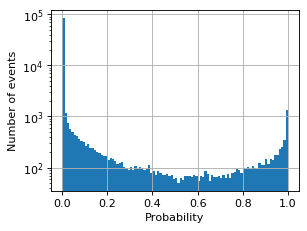

In [109]:
fig, ax = plt.subplots(figsize=(4,3))
flight_df_gtu_36_45_pack_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_36_45_pack_nonan_' + cls_proba_column +'_distribution_horizontal.svg'))
plt.show()

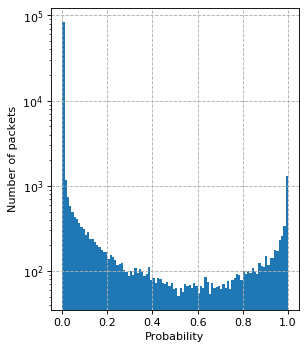

In [110]:
fig, ax = plt.subplots(figsize=(4,5))
flight_df_gtu_36_45_pack_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.grid(linestyle='--')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_36_45_pack_nonan_' + cls_proba_column +'_distribution_vertical.svg'))
plt.show()

#### Events classified "air shower" - fraction of all events

<big>CAUTION: from this point only flight_df_gtu_36_45_pack_nonan</big>

In [111]:
np.count_nonzero(flight_df_gtu_36_45_pack_nonan[cls_column])/num_all_events

0.02486292839929483

#### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [112]:
np.count_nonzero(flight_df_gtu_36_45_pack_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.03865350766909731

#### Packets classified "air shower" - fraction of all packets

In [113]:
num_cls_1_packets = \
    len(flight_df_gtu_36_45_pack_nonan[flight_df_gtu_36_45_pack_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [114]:
print('num_cls_1_packets', num_cls_1_packets)

num_cls_1_packets 6149


In [115]:
num_cls_1_packets/num_all_packets

0.04145570260303249

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [116]:
num_cls_1_gtu_36_60_packets = \
    len(flight_df_gtu_36_45_pack_nonan[flight_df_gtu_36_45_pack_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [117]:
print('num_cls_1_gtu_36_60_packets', num_cls_1_gtu_36_60_packets)

num_cls_1_gtu_36_60_packets 6149


In [118]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_packets

0.043963822257176564

### Distribution of classified events by date

In [119]:
mpl.rcParams.update(mpl.rcParamsDefault)

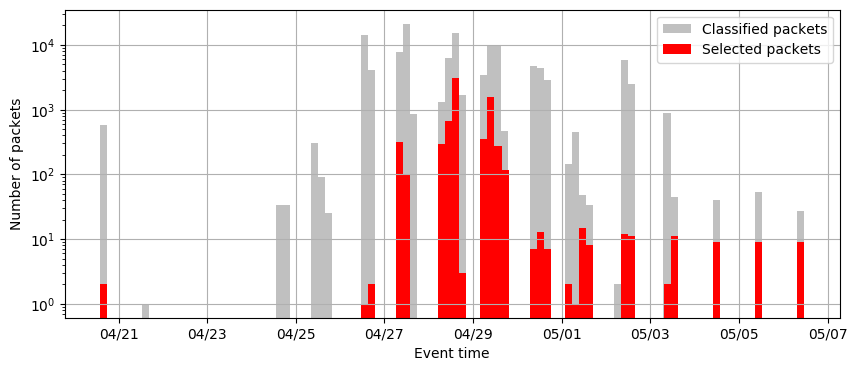

In [120]:
# TODO incorrect plot, see ver4_machine_learning_flight_classification_tsne_cfg3_20190628_2_gtu_40_overlap_cls20190728.ipynb

fig, ax = plt.subplots(figsize=(10,4))
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='Classified packets')
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected packets')
ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_by_date_log.svg'))
plt.show()

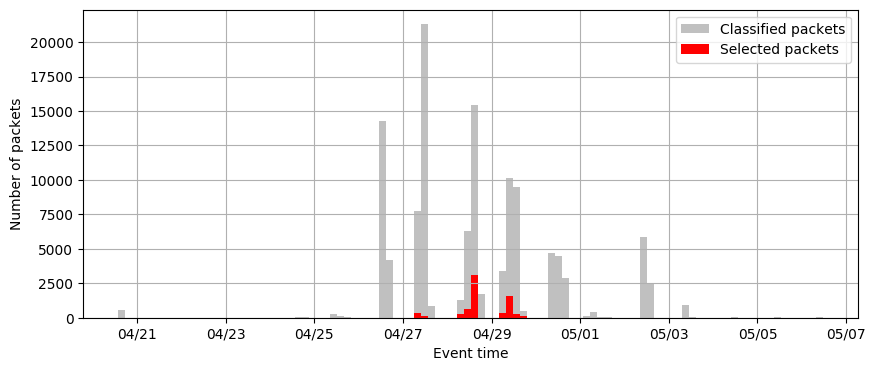

In [121]:
# TODO incorrect plot, see ver4_machine_learning_flight_classification_tsne_cfg3_20190628_2_gtu_40_overlap_cls20190728.ipynb


fig, ax = plt.subplots(figsize=(10,4))
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='Classified packets')
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_by_date_linear.svg'))
plt.show()

### GTU In packet

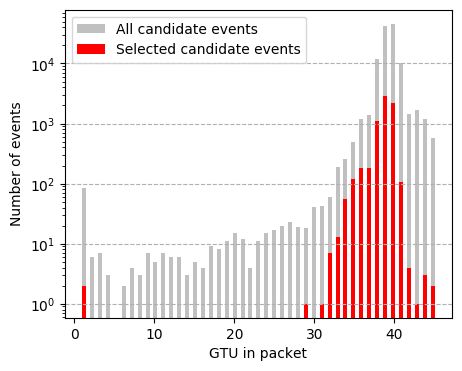

In [122]:
fig, ax = plt.subplots(figsize=(5,4))
ax.grid(which='major', axis='y', linestyle='--')
h = ax.hist(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'], bins=(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'].max() - flight_df_gtu_overlap_pack_nonan['gtu_in_packet'].min())*2 + 1, color='silver', label='All candidate events')
# flight_df_nonan['gtu_in_packet'].hist(ax=ax, bins=65)
# flight_df_nonan['gtu_in_packet'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=h[1], color='red', label='Selected candidate events')
ax.hist(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1], bins=h[1], color='red', label='Selected candidate events')
ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('GTU in packet')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_gtu_in_packet_log.svg'))
plt.show()

In [123]:
# TODO 
# - trigger rate S
# - trigger rate by manual classification

### Trigger rate

#### All flight HW events

In [124]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [125]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

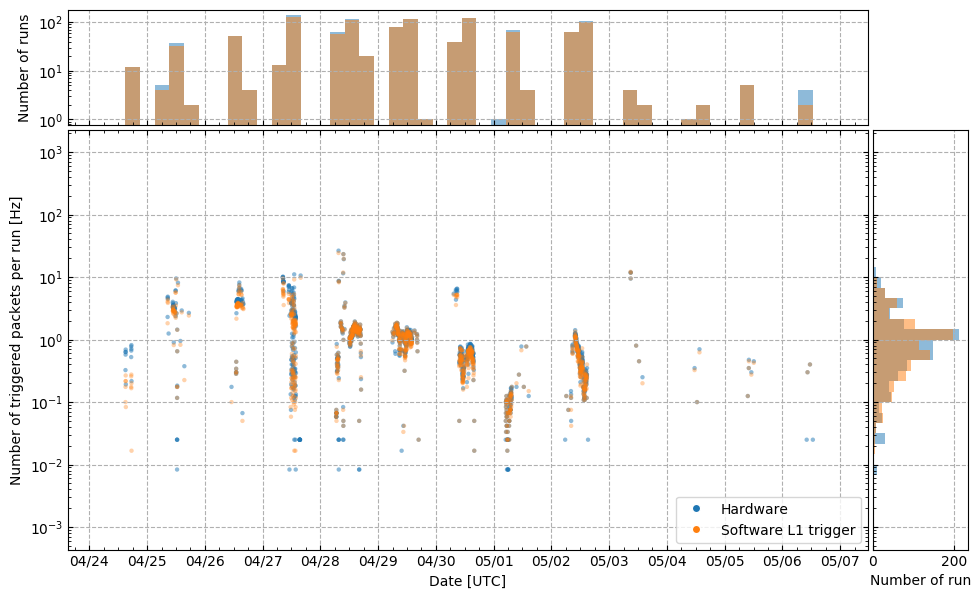

In [126]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);
# dodgerblue

#### All classified events

In [127]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

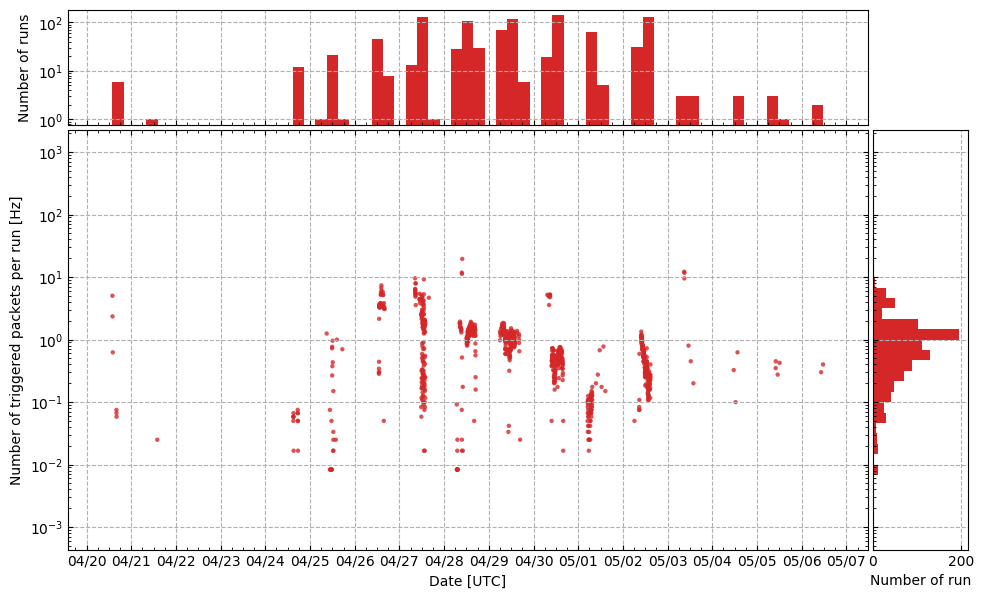

In [128]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all.png')
);
# limegreen

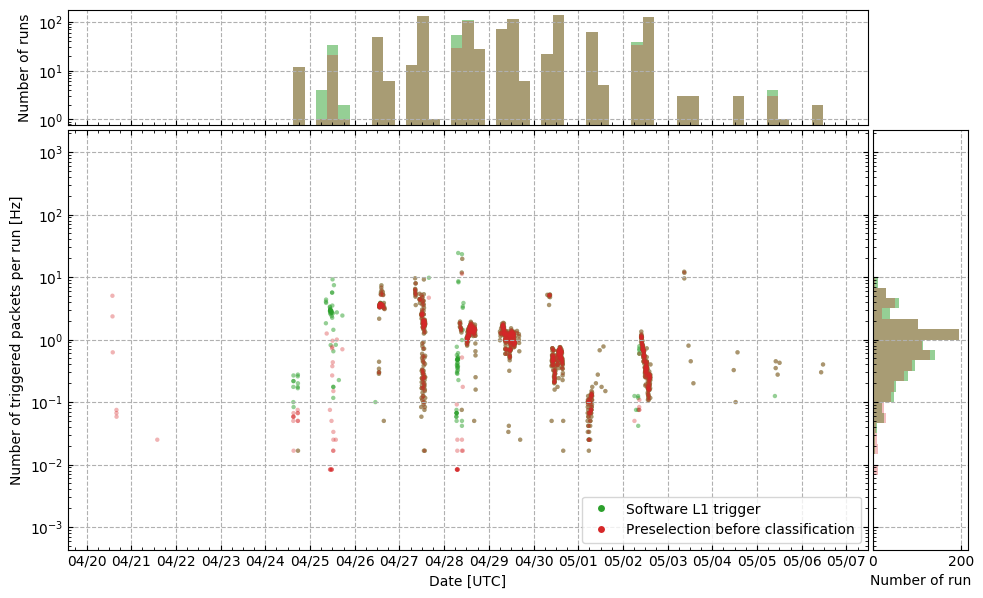

In [129]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

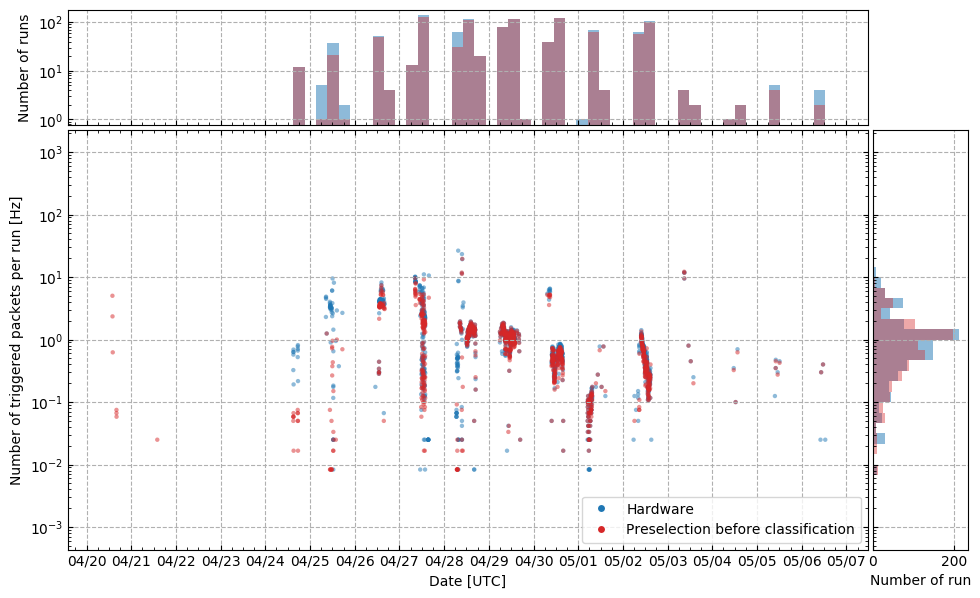

In [130]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.4, scatter_alpha=.5,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

#### Events classified as "air shower"

In [131]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[cls_column] == 1],  one_trg_per='packet')

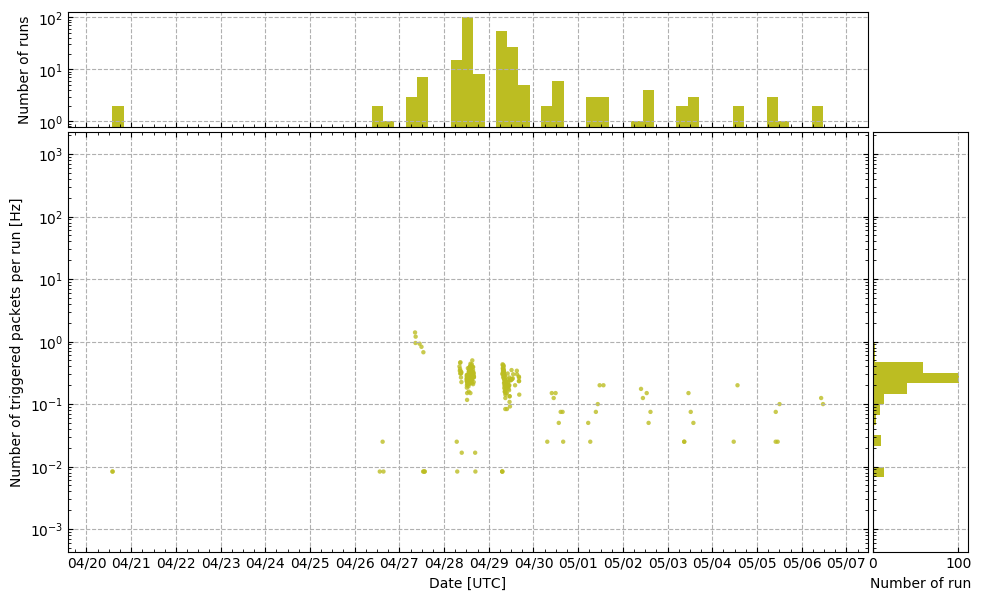

In [132]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_classified_air_shower.png')
);

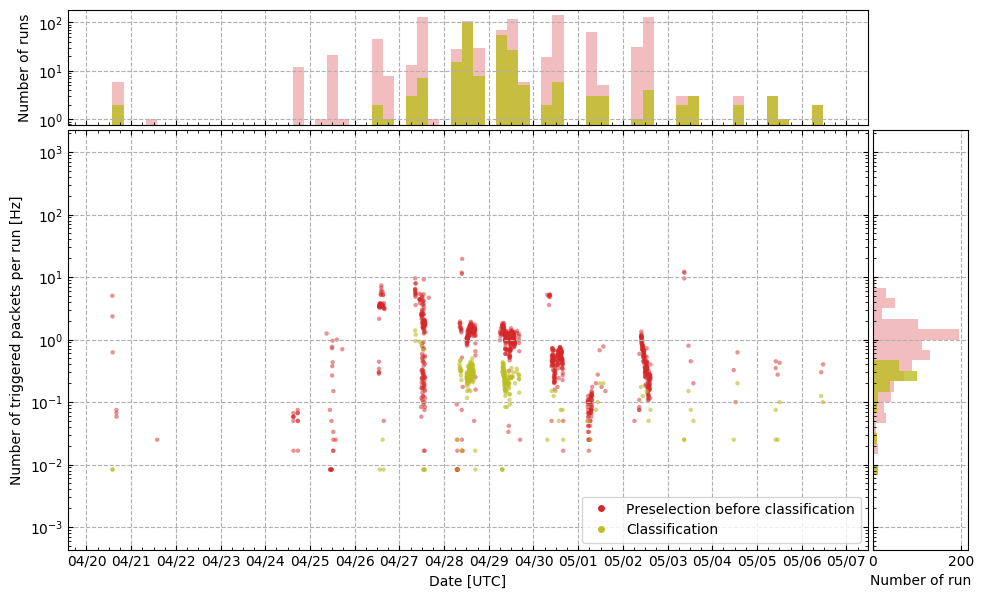

In [133]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_classified_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

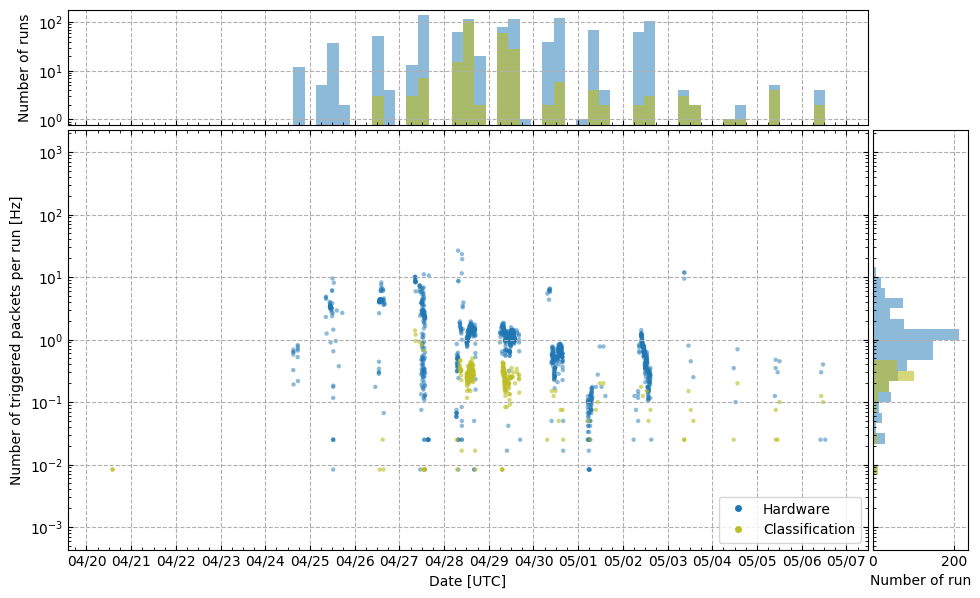

In [134]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.6, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_hw_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

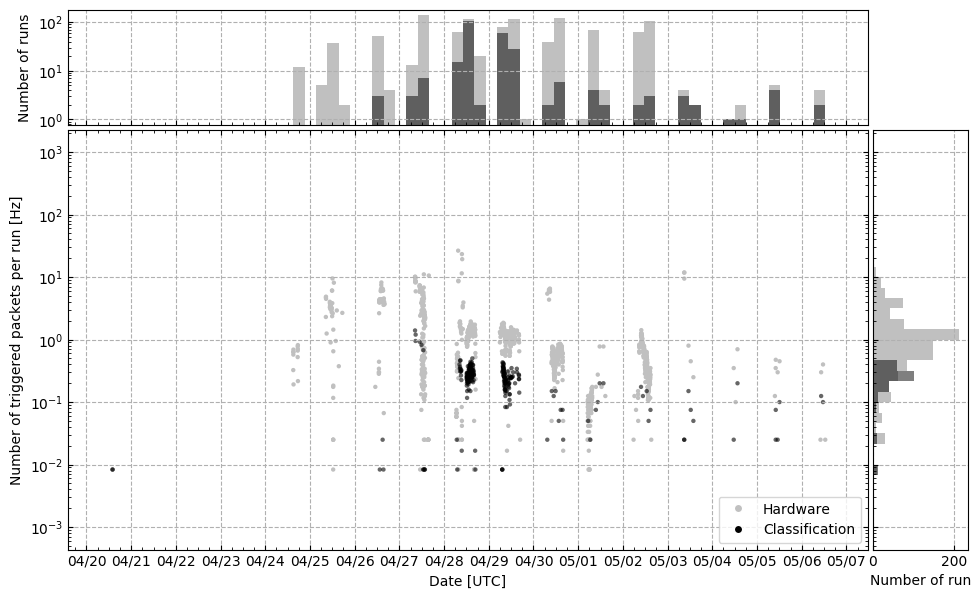

In [135]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

#### Summary - mean trigger rate

In [136]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         1.172233333333333
Mean trigger rate in classifer selected data: 0.24961389961389963


### Distribution of classified events by manual classification

In [137]:
sns.set(style="whitegrid")

In [138]:
flight_df_gtu_overlap_pack_nonan[manual_classification_class_label_column].value_counts()

Unclassified                115510
Pixel                          708
Pixel with a blob behind       429
Blob                           415
Top-left EC                    386
Sudden bg. increased           317
Single GTU track               218
Unspecified noise              211
Few pixels                     200
Large blob                     196
Short single GTU track         188
Bright blob                    141
Persistent pixel               134
Noise                          129
2 pix line                      96
Cartesian line                  73
Sparse blobs                    61
Noise with a weak pixel         43
Unspecified                     42
Blob and pixels                 36
Storng light                    18
Name: manual_classification_class_label, dtype: int64

Withount unclassified
All flight data in the selection


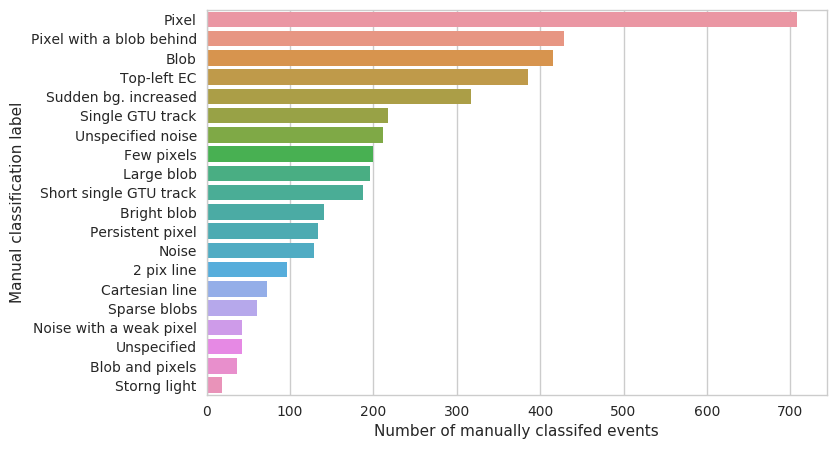

Events classified as positive


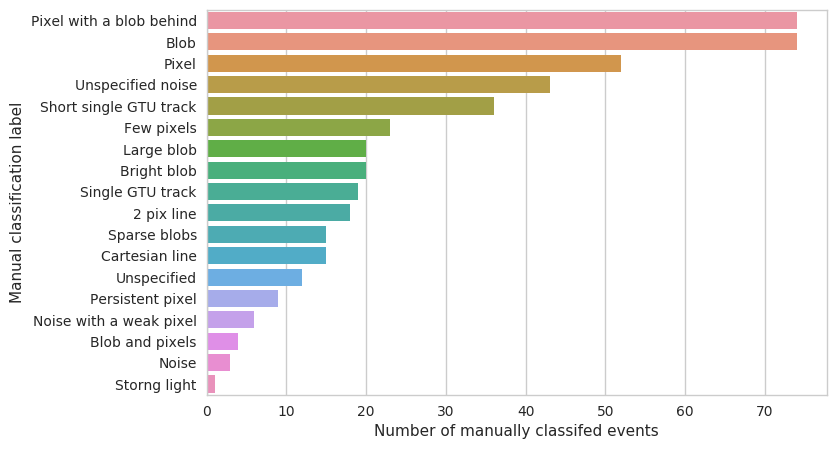

With unclassified
All flight data in the selection


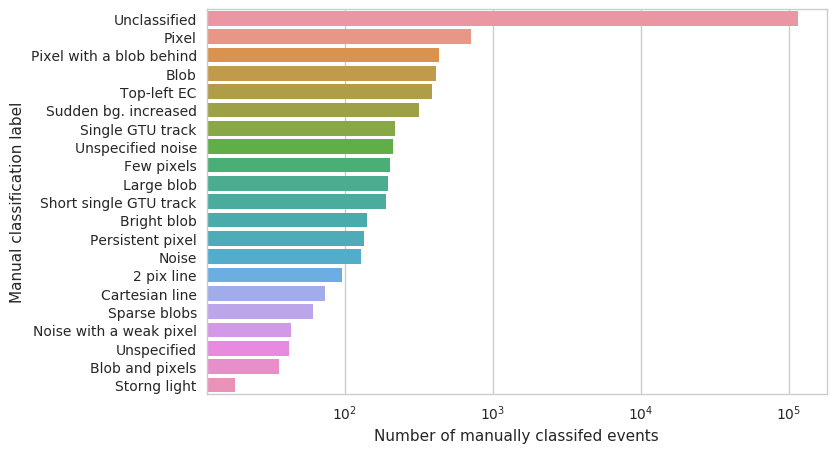

Events classified as positive


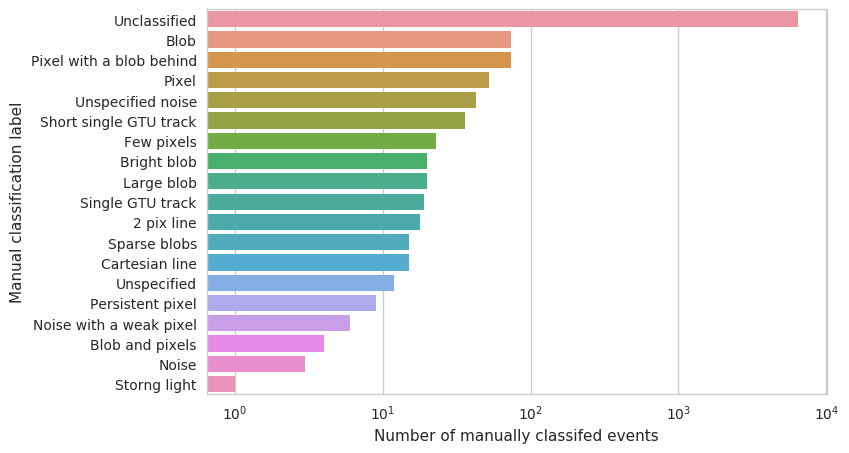

In [139]:
# requires manual_classification_class_label_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_gtu_overlap_pack_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_label_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_label_column].value_counts().index,
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

Withount unclassified
42
ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution_ver2.svg


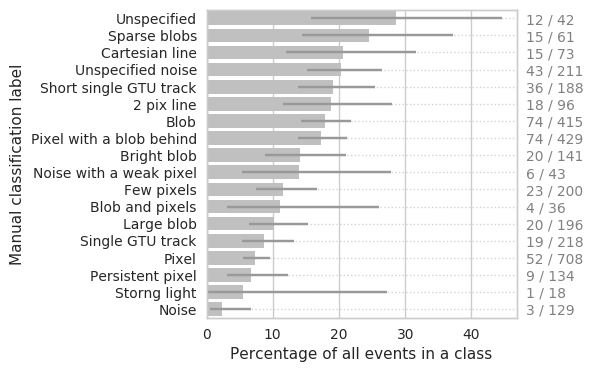

With unclassified
42
ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution_with_unclassified_ver2.svg


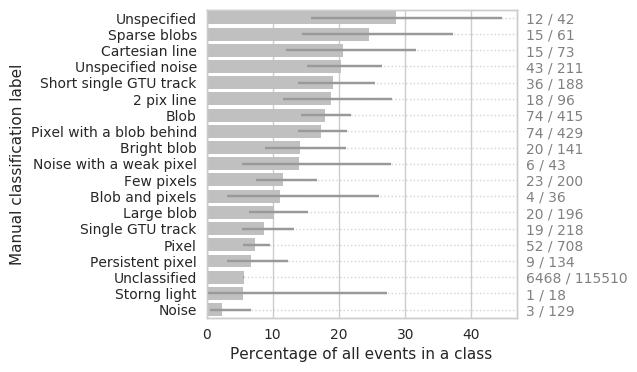

In [140]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_gtu_overlap_pack_nonan[
            flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_gtu_overlap_pack_nonan

#     flight_data_nonan_class_ratios_df = \
#         subset_df.groupby([manual_classification_class_label_column])[cls_column] \
#             .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)


#     subset_df = pd.DataFrame(flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1])
    
#     subset_df['e1'] = np.random.randint(3, size=len(subset_df))
#     subset_df['e2'] = np.random.randint(4, size=len(subset_df)) + 1
    
    print(np.count_nonzero(subset_df[manual_classification_class_number_column] == EVENT_CLASSES['unspecified']))
        
    manual_classification_class_count_df = \
        subset_df.groupby([manual_classification_class_label_column])['event_id'].count()
    manual_classification_class_positive_count_df = \
        subset_df[subset_df[cls_column] == 1].groupby([manual_classification_class_label_column])['event_id'].count()
#     manual_classification_class_negative_count_df = \
#         subset_df[subset_df[cls_column] == 0].groupby([manual_classification_class_label_column])['event_id'].count()
    manual_classification_class_in_positive_count_df = \
        manual_classification_class_count_df[
            np.isin(manual_classification_class_count_df.index, manual_classification_class_positive_count_df.index)
        ]
#     manual_classification_class_in_negative_count_df = \
#         manual_classification_class_count_df[
#             np.isin(manual_classification_class_count_df.index, manual_classification_class_negative_count_df.index)
#         ]

    fraction_ser = manual_classification_class_positive_count_df / manual_classification_class_count_df[manual_classification_class_positive_count_df.index]
    fraction_ser.sort_values(ascending=False, inplace=True)
    
    err = sm_stats_proportion.proportion_confint(
        manual_classification_class_positive_count_df[fraction_ser.index],
        manual_classification_class_count_df[fraction_ser.index], 
        alpha=0.05, 
        method='beta'
    )
    
    xerr = (
        (fraction_ser - err[0])*100,
        (err[1] - fraction_ser)*100
    )
    
    fig, ax = plt.subplots(1, figsize=(4,4))
    p = sns.barplot(
                    y=fraction_ser.index,
                    x=fraction_ser*100,
                    xerr=xerr,
#                     y=manual_classification_class_label_column, 
#                     x="percentage", #hue=cls_column, 
#                     data=subset_df, 
                    ax=ax, orient='h',
#                     order=subset_df[manual_classification_class_label_column].iloc[
#                         np.argsort(-subset_df["percentage"])],
#                     palette="gist_rainbow"
                    color="silver",
                    ecolor="#999999"
                   )
    ax.set_zorder(0)
    ax.patch.set_alpha(0)
    ax2 = ax.twinx()
    ax.set_zorder(3)
    ax2.set_yticks(np.arange(len(fraction_ser)))
    ax2.set_ylim(ax.get_ylim())
    ax2.grid(linestyle=':', color="lightgray")
    ax2.set_yticklabels(
        ['{} / {}'.format(v1, v2) for v1, v2 in zip(
            manual_classification_class_positive_count_df[fraction_ser.index], 
            manual_classification_class_in_positive_count_df[fraction_ser.index])]
    )
    ax2.tick_params(axis='y', colors='gray')

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution{}_ver2.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))
    print(flight_data_manual_classification_class_name_dist_fig_pathname)
    
# #     if w_unclassified:
# #         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

Withount unclassified


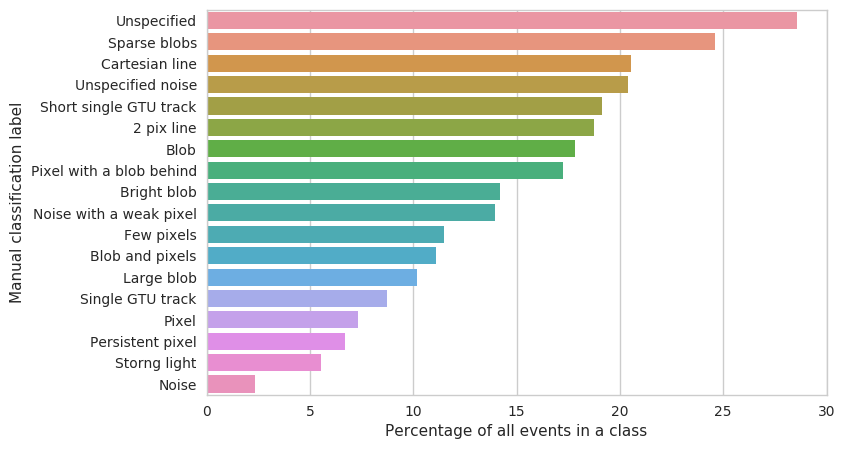

With unclassified


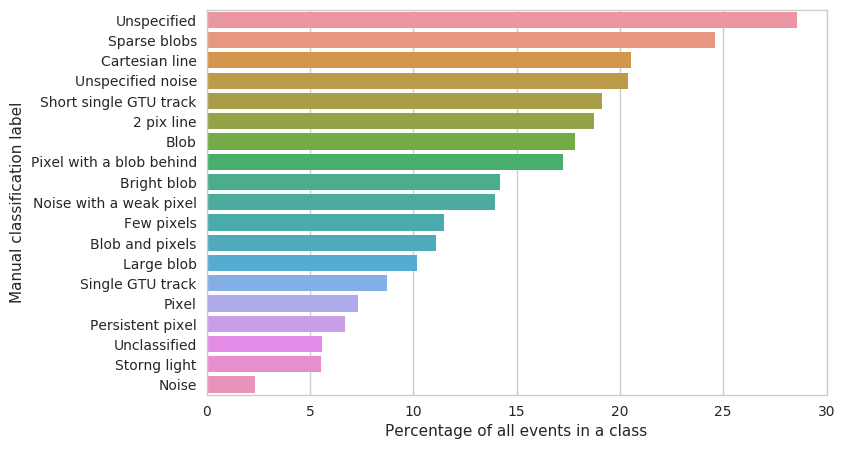

In [141]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_gtu_overlap_pack_nonan[
            flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_gtu_overlap_pack_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_label_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_label_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_label_column].iloc[
                        np.argsort(-subset_df["percentage"])],
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

In [142]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [143]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [144]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df_gtu_overlap_pack_nonan.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Saving ver4_machine_learning_flight_classification_20190628_2_gtu_40_overlap_cls20190728__convnet_szakacs_triple_net/flight_df_gtu_overlap_pack_nonan_flight_data.tsv.gz


# Visualization of the events

## T-SNE

Using T-SNE computed on flight_df_nonan, visualizing flight_df_gtu_overlap_pack_nonan

In [ ]:
# %load_ext wurlitzer
# # from sklearn.manifold import TSNE
# import MulticoreTSNE
# from sklearn.externals import joblib

In [ ]:
# load_existing_tsne_model = True
# refit_tsne_model = False
# dump_tsne_embedding = True
# show_plots = True

### Fitting

In [ ]:
# tsne_hyperparams_dict = dict(
#     learning_rate=100,
#     n_iter=5000,
#     perplexity=50, 
#     angle=0.3,
#     verbose=10,
#     random_state=9621
# )

In [ ]:
# num_columns_list = list(range(50, len(rfecv_selector_on_extra_trees__column_names)+1, 50))

# if (len(rfecv_selector_on_extra_trees__column_names)-50) % 50 != 0:
#     num_columns_list += [len(rfecv_selector_on_extra_trees__column_names)]

In [ ]:
# num_columns_list

In [ ]:
# rfecv_selector_on_extra_trees__column_names__sorted

In [ ]:
# tsne_hyperparams_dict_md5str = hashlib.md5(';'.join(['{}={}'.format(k,v) for k,v in sorted(tsne_hyperparams_dict.items())]).encode()).hexdigest()

# flight_rfecv_columns__X_tsne_dict = {}
# tsne_on_flight_nonan_rfecv_columns_X_pathname_dict = {}
# tsne_on_flight_nonan_rfecv_columns_divergences_dict = {}
# tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict = {}

# for num_columns in num_columns_list:
    
#     tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns] = \
#         os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__X.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
#     tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns] = \
#         os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__kl_divergence.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
#     print('Fitting T-SNE of {} features'.format(num_columns))
#     print('Pickled file pathname', tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
    
#     if refit_tsne_model or not os.path.exists(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns]):
#         tsne_on_flight_nonan_rfecv_columns = MulticoreTSNE.MulticoreTSNE(**tsne_hyperparams_dict, n_jobs=6)
#         flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.fit_transform(
#             flight_rfecv_columns__X.T[rfecv_selector_on_extra_trees__column_indices__sorted[:num_columns+1]].T)
#         tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.kl_divergence_
# #         if dump_tsne_model: 
# #             joblib.dump(tsne_on_flight_nonan_rfecv_columns, tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns], compress=1)
#         if dump_tsne_embedding:
#             np.save(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns], flight_rfecv_columns__X_tsne_dict[num_columns])
#             np.save(tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns], tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns])
        
#     else:
# #         tsne_on_flight_nonan_rfecv_columns = joblib.load(tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns])
# #         flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.embedding_
#         flight_rfecv_columns__X_tsne_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
#         tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns])

# Save classification results

In [ ]:
# classification_column_names = [col for col in flight_df_gtu_overlap_pack_nonan.columns \
#                                if col.startswith('tsne_') or \
#                                        col == cls_column or col == cls_proba_column or \
#                                        col == event_v3_storage_provider_flight.data_table_pk]
# classification_column_type = [(int \
#                                if col == cls_column or col.endswith('dbscan_y') or \
#                                        col == event_v3_storage_provider_flight.data_table_pk or \
#                                        col == event_v3_storage_provider_flight.data_table_pk \
#                                    else float) \
#                               for col in classification_column_names]

# classification_columns = list(zip(classification_column_names, classification_column_type))


# print('-'*50)
# print(subset_classification_slug)
# print(classification_column_names)

# event_v3_storage_provider_flight.create_classification_table(subset_classification_slug, classification_columns)

# event_v3_storage_provider_flight.save_classification_data(
#     subset_classification_slug, 
#     flight_df_gtu_overlap_pack_nonan[classification_column_names].values, classification_columns, 
#     num_inserts_at_once=1000, morgify=False
# )